<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/colab_h_lda_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [1]:
pip install wandb

In [2]:
!wandb login

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [3]:
!pip uninstall gensim -y

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [4]:
!pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [5]:
pip install pyLDAvis

In [6]:
import wandb

In [7]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os
import zipfile
from gensim.models.phrases import Phrases

In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [9]:
print(gensim.__version__)

4.1.2


In [10]:
!rm data.csv

In [11]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Configuration


In [12]:
use_wandb = True

In [13]:
generate_webapp_data = False

In [83]:
#docu = 'sections'
docu = 'tunes'
chords_preprocessing = 'rootAndDegreesSimplified'

In [84]:
phrases_threshold = 1.0  # 1.0 for no phrases

In [85]:
remove_repetitions = False

In [86]:
ngrams_for_input = [1]

In [87]:
input_files = {
    'sections': {
        # M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.
        'rootAndDegreesPlus': '1BDYukaIj72jmi9PqZVrCAqKbyxg8Z4yq',
        'rootAndDegrees7': '',
        'rootAndDegreesSimplified': '1h9dRRpbTSEE_x9CpbQ9rOi-GXKcCFUCU'
    },
    'tunes': {
        'rootAndDegreesPlus': '1PhLEjyD4oNfFDm8N9_rDTXQmzkIk759w',
        'rootAndDegrees7': '',
        'rootAndDegreesSimplified': '1WtxC58-xpk99nmGfrp28kg6ftLfMnLXT',
    }
}

In [88]:
tunes_eval_list = [
  "Sweet Sue, Just You [jazz1350]",
  "On The Sunny Side Of The Street [jazz1350]",
  "These Foolish Things [jazz1350]", 
  "Blue Moon [jazz1350]",
  "All Of Me [jazz1350]",
  "All God's Chillun Got Rhythm [jazz1350]",
  "I Got Rhythm [jazz1350]",
  "Bye Bye Blackbird [jazz1350]",
  "Old Fashioned Love [trad]",
  "Exactly Like You [jazz1350]",
  "Honeysuckle Rose [jazz1350]",
  "Misty [jazz1350]",
  "Naima [jazz1350]",
]

tunes_eval_list = sorted(tunes_eval_list)
tunes_eval_list

["All God's Chillun Got Rhythm [jazz1350]",
 'All Of Me [jazz1350]',
 'Blue Moon [jazz1350]',
 'Bye Bye Blackbird [jazz1350]',
 'Exactly Like You [jazz1350]',
 'Honeysuckle Rose [jazz1350]',
 'I Got Rhythm [jazz1350]',
 'Misty [jazz1350]',
 'Naima [jazz1350]',
 'Old Fashioned Love [trad]',
 'On The Sunny Side Of The Street [jazz1350]',
 'Sweet Sue, Just You [jazz1350]',
 'These Foolish Things [jazz1350]']

In [89]:
contrafacts = [
               ("26-2 [jazz1350]", "Confirmation [jazz1350]"),
               ("52nd Street Theme [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Ablution [jazz1350]", "All The Things You Are [jazz1350]"),
               ("Anthropology [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Ballade [jazz1350]", "As Long As I Live [jazz1350]"),
               ("Bright Mississippi [jazz1350]", "Sweet Georgia Brown [jazz1350]"),
               ("C.T.A. [jazz1350]", "I Got Rhythm [jazz1350]"),
               #( "Celia [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Cottontail [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Countdown [jazz1350]", "Tune Up [jazz1350]"),
               ("Dewey Square [jazz1350]", "Oh, Lady Be Good [jazz1350]"),
               ("Dexterity [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Dig [jazz1350]", "Sweet Georgia Brown [jazz1350]"),
               ("Donna Lee [jazz1350]", "Indiana (Back Home Again In) [jazz1350]"),
               ("Don't Be That Way [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Eternal Triangle [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Evidence [jazz1350]", "Just You, Just Me [jazz1350]"),
               ("Flintstones [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Four On Six [jazz1350]", "Summertime [jazz1350]"),
               ("Freight Train [jazz1350]", "Blues For Alice [jazz1350]"),
               ("Good Bait [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Hackensack [jazz1350]", "Oh, Lady Be Good [jazz1350]"),
               ("Half Nelson [jazz1350]", "Lady Bird [jazz1350]"),
               ("Hot House [jazz1350]", "What Is This Thing Called Love [jazz1350]"),
               ("Impressions [jazz1350]", "So What [jazz1350]"),
               ("In A Mellow Tone (In A Mellotone) [jazz1350]", "Rose Room [jazz1350]"),
               ("In Walked Bud [jazz1350]", "Blue Skies [jazz1350]"),
               ("Ko Ko [jazz1350]", "Cherokee [jazz1350]"),
               ("Lennie's Pennies [jazz1350]", "Pennies From Heaven [jazz1350]"),   ## Lennie's Pennies is in minor and therefore transposed to Amin... not possible to recognize like that
               #( "Let's Call This [jazz1350]", "Honeysuckle Rose [jazz1350]"),
               ("Little Rootie Tootie [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Little Willie Leaps [jazz1350]", "All God's Chillun Got Rhythm [jazz1350]"),
               ("Lullaby Of Birdland [jazz1350]", "Love Me Or Leave Me [jazz1350]"),
               #("Moose The Mooche [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("My Little Suede Shoes [jazz1350]", "Jeepers Creepers [jazz1350]"),
               #("Oleo [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Ornithology [jazz1350]", "How High The Moon [jazz1350]"),
               #("Passport [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Quasimodo (Theme) [jazz1350]", "Embraceable You [jazz1350]"),
               #("Rhythm-a-ning [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Room 608 [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Salt Peanuts [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Satellite [jazz1350]", "How High The Moon [jazz1350]"),
               ("Scrapple From The Apple [jazz1350]", "Honeysuckle Rose [jazz1350]"), # A section
               ("Scrapple From The Apple [jazz1350]", "I Got Rhythm [jazz1350]"), # B section
               #("Segment [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Seven Come Eleven [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Shaw 'Nuff [jazz1350]", "I Got Rhythm [jazz1350]"),
               #("Theme, The [jazz1350]", "I Got Rhythm [jazz1350]"),
               ("Tour De Force [jazz1350]", "Jeepers Creepers [jazz1350]"),
               ("Wow [jazz1350]", "You Can Depend On Me [jazz1350]"),
               ("Yardbird Suite [jazz1350]", "Rosetta [jazz1350]"),

               # following tunes are not from wikipedia),
               ("Sweet Sue, Just You [jazz1350]", "Honeysuckle Rose [jazz1350]"),  # A section
               #("All Of Me [jazz1350]", "Pennies From Heaven [jazz1350]"), # bars 25-28 of All of Me are same as bars 17-20 of Pennies From Heaven, but different key!
               ("Sweet Sue, Just You [jazz1350]", "Bye Bye Blackbird [jazz1350]"), # Bridge same
               ("These Foolish Things [jazz1350]", "Blue Moon [jazz1350]"), # first 8 bars same
               ("These Foolish Things [jazz1350]", "More Than You Know [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Isn't It A Pity [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Soultrain [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Why Do I Love You [jazz1350]"),
               ("Misty [jazz1350]", "Portrait Of Jennie [jazz1350]"),
               ("Misty [jazz1350]", "September In The Rain [jazz1350]"),
               ("Misty [jazz1350]", "I May Be Wrong [jazz1350]"),  

               # identical tunes
               ("Five Foot Two [trad]", "Please Don't Talk About Me When I'm Gone [trad]"),
               ("What Is This Thing Called Love [jazz1350]", "Subconscious Lee [jazz1350]"),
               ("Sweet Georgia Brown [jazz1350]", "Dig [jazz1350]"),


               # almost identical tunes
               ("What Is This Thing Called Love [jazz1350]", "Hot House [jazz1350]"),
               ("Jeannie's Song [jazz1350]", "Shiny Stockings [jazz1350]"),
               ("Alone Together [jazz1350]", "Segment [jazz1350]"),
               ("Baubles, Bangles and Beads [jazz1350]", "Bossa Antigua [jazz1350]"),
               ("There Will Never Be Another You [jazz1350]", "A Weaver Of Dreams [jazz1350]"),
               ("Moten Swing [jazz1350]", "Once In A While (Ballad) [trad]"), # same bridge, similar A
               ("All I Do Is Dream Of You [trad]", "L-O-V-E [jazz1350]"),


               # same A section
               ("Nancy (With The Laughing Face) [jazz1350]", "Body And Soul [jazz1350]"),
               ("Exactly Like You [jazz1350]", "True (You Don't Love Me ) [trad]"),
               ("Exactly Like You [jazz1350]", "True (You Don't Love Me ) [trad]"),
               ("Exactly Like You [jazz1350]", "Jersey Bounce [trad]"),
               ("Take The A Train [jazz1350]", "Girl From Ipanema, The [jazz1350]"),
               ("My Heart Stood Still [jazz1350]", "All Too Soon [jazz1350]"),
               ("Undecided [jazz1350]", "Broadway [jazz1350]"),
               ("My Heart Stood Still [jazz1350]", "All Too Soon [jazz1350]"),
               ("Let's Fall In Love [jazz1350]", "Heart And Soul [jazz1350]"),
               ("Come Back To Me [jazz1350]", "I Wish I Knew [jazz1350]"),
               ("Wait Till You See Her [jazz1350]", "A Certain Smile [jazz1350]"),
               ("Killer Joe [jazz1350]", "Straight Life [jazz1350]"),
               ("Softly, As In A Morning Sunrise [jazz1350]", "Segment [jazz1350]"),
               ("Bei Mir Bist Du Schon (Root Hog Or Die) [trad]", "Egyptian Fantasy [trad]"),
               ("Bei Mir Bist Du Schon (Root Hog Or Die) [trad]", "Puttin' On The Ritz [jazz1350]"),
               ("Coquette [trad]", "Pretend You're Happy When You're Blue [trad]"),
               ("Softly, As In A Morning Sunrise [jazz1350]", "Strode Rode [jazz1350]"),
               ("Glory Of Love, The [jazz1350]", "I've Got My Fingers Crossed [trad]"),


               # same bridge
               ("If I Had You [jazz1350]", "Too Young To Go Steady [jazz1350]"),
               ("Undecided [jazz1350]", "Satin Doll [jazz1350]"),
               ("Billy Boy [jazz1350]", "Elora [jazz1350]"),
               ("Dearly Beloved [jazz1350]", "We See [jazz1350]"),
               ("Alone Together [jazz1350]", "A Night In Tunisia [jazz1350]"),
               ("A Night In Tunisia [jazz1350]", "Segment [jazz1350]"),
               ("Oh! Lady Be Good [trad]", "Sentimental Journey [jazz1350]"),
               ("You Can Depend On Me [jazz1350]", "Move [jazz1350]"),
               ("I Want To Be Happy [jazz1350]", "A Beautiful Friendship [jazz1350]"),
               ("Flying Home [jazz1350]", "Down For Double [jazz1350]"),
               ("Cheek To Cheek [jazz1350]", "Violets For Your Furs [jazz1350]"),
               ("Let's Fall In Love [jazz1350]", "At Last [jazz1350]"),
               ("Don't Be That Way [jazz1350]", "Long Ago And Far Away [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "I'm Confessin' That I Love You [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "Eclypso [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "You Stepped Out Of A Dream [jazz1350]"),
               

               # similar A section
               ("I Like The Likes Of You [jazz1350]", "Mountain Greenery [jazz1350]"),
               ("My Secret Love [jazz1350]", "Samba De Orfeu [jazz1350]"),
               ("Let's Call The Whole Thing Off [jazz1350]", "Fine And Dandy [jazz1350]"),


               # similar B section
               ("Folks Who Live On The Hill, The [jazz1350]", "My One And Only Love [jazz1350]"),
               ("As Long As I Live [jazz1350]", "I'm Glad There Is You [jazz1350]"),
               ("I May Be Wrong [jazz1350]", "Teach Me Tonight [jazz1350]"),
               ("Am I Blue [jazz1350]", "Come Back To Me [jazz1350]"),
               ("My One And Only Love [jazz1350]", "Am I Blue [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "September In The Rain [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "Mountain Greenery [jazz1350]"),
               ("On The Sunny Side Of The Street [jazz1350]", "There's No You [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Embraceable You [jazz1350]"),
               ("These Foolish Things [jazz1350]", "Rosetta [jazz1350]"),

               # same C section
               ("Bill Bailey [jazz1350]", "Bourbon Street Parade [jazz1350]"),

               # Stella C is like Woody B
               ("Woody'n You [jazz1350]", "Stella By Starlight [jazz1350]"),

               # similar vocabulary, different progressions
               ("Tangerine [jazz1350]", "Tea For Two [jazz1350]"),
               ("I Can't Give You Anything But Love [jazz1350]", "You Can Depend On Me [jazz1350]"),
               ("This Year's Kisses [jazz1350]", "My Monday Date [trad]"),
               ("A Blossom Fell [jazz1350]", "Among My Souvenirs [jazz1350]"),



]

# Initialization

## Download the Data

In [90]:
input_data = input_files[docu][chords_preprocessing]

input_path = f"https://docs.google.com/uc?export=download&id={input_data}"
data_file_name = 'data.csv'


In [91]:
input_path

'https://docs.google.com/uc?export=download&id=1WtxC58-xpk99nmGfrp28kg6ftLfMnLXT'

In [92]:
!wget --no-check-certificate "$input_path" -O "$data_file_name"

--2021-11-29 20:09:28--  https://docs.google.com/uc?export=download&id=1WtxC58-xpk99nmGfrp28kg6ftLfMnLXT
Resolving docs.google.com (docs.google.com)... 172.253.119.113, 172.253.119.139, 172.253.119.100, ...
Connecting to docs.google.com (docs.google.com)|172.253.119.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2qdaq6sop6c9iobmj7pfbj7coet6gbp4/1638216525000/14329102864480165501/*/1WtxC58-xpk99nmGfrp28kg6ftLfMnLXT?e=download [following]
--2021-11-29 20:09:28--  https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2qdaq6sop6c9iobmj7pfbj7coet6gbp4/1638216525000/14329102864480165501/*/1WtxC58-xpk99nmGfrp28kg6ftLfMnLXT?e=download
Resolving doc-0s-4c-docs.googleusercontent.com (doc-0s-4c-docs.googleusercontent.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to doc-0s-4c-docs.googleusercontent.com (doc-0s

### Read Chords Input Data

In [93]:
df = pd.read_csv(data_file_name, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,title_playlist,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,NaN,0,CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 G#7 C#M7 E7 Am7 D7 Dm7 G7 CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 Eb7 G#M7 B7 EM7 G7 CM7 Gm7 C7 Bm7 E7 AM7 C7 FM7 Bbm7 Eb7 G#M7 Dm7 G7 CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 Eb7 G#M7 B7 EM7 G7 CM7
1,1,dataset/jazz1350/500 Miles High.xml,500 Miles High,500 Miles High [jazz1350],minor,1,NaN,0,Am7 Am7 Cm7 Cm7 EbM7 EbM7 Em7b5 A7 Dm7 Dm7 Bm7b5 Bm7b5 Bbm7 Bbm7 Fm7 Fm7 E7 E7 Fm7 Fm7 C#M7 C#M7 Fm7 Fm7 C#M7 C#M7
2,2,dataset/jazz1350/502 Blues.xml,502 Blues,502 Blues [jazz1350],minor,2,NaN,0,Am7 C#M7 Bm7b5 E7 Am7 C#M7 Bm7b5 E7 Cm7 F7 BbM7 G#m7 C#7 F#m7b5 B7 EM7 EM7 E7 Am7 C#M7 Bm7b5 E7 Am7 C#M7 Bm7b5 E7 Cm7 F7 BbM7 G#m7 C#7 F#m7b5 B7 Em7 Em7
3,3,dataset/jazz1350/52nd Street Theme.xml,52nd Street Theme,52nd Street Theme [jazz1350],major,3,NaN,0,C Am7 Dm7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C G7 C C Am7 Dm7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C G7 C C7 C7 F6 F6 D7 D7 G7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C Am7 Dm7 G7 C G7 C
4,4,dataset/jazz1350/9.20 Special.xml,9.20 Special,9.20 Special [jazz1350],major,4,NaN,0,C7 Ebm6 C7 Ebm6 Bb Bb7 A7 G#7 G7 C7 F#dim7 C7 G#7 G7 C7 Ebm6 C7 Ebm6 Bb Bb7 A7 G#7 G7 C7 F#dim7 C7 F7 Bb Bb Eb Eb6 Eb6 Eb6 G7 F F6 F7 F7 C7 Ebm6 C7 Ebm6 Bb Bb7 A7 G#7 G7 C7 F#dim7 C6 F7 Bb D7


### Meta Data

In [94]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'title_playlist', 'tune_mode']]
titles[:5]

,id,tune_id,section_id,section_name,title,title_playlist,tune_mode
0,0,0,0,NaN,26-2,26-2 [jazz1350],major
1,1,1,0,NaN,500 Miles High,500 Miles High [jazz1350],minor
2,2,2,0,NaN,502 Blues,502 Blues [jazz1350],minor
3,3,3,0,NaN,52nd Street Theme,52nd Street Theme [jazz1350],major
4,4,4,0,NaN,9.20 Special,9.20 Special [jazz1350],major


In [95]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title_playlist']
sectionid_to_titleid = titles_dict['tune_id']


In [96]:
tunes = df.loc[:, ['tune_id', 'title_playlist']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title_playlist']

In [97]:
title_to_titleid = {v: k for k, v in titleid_to_title.items()}


In [98]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [99]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title_playlist']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

### Create Directories on Colab

In [100]:
!rm -R output
!mkdir output

## Initialization for wandb variables

In [101]:
recommender_results_cols = ['reference', 'id', 'method', 'similar', 'score_div_max', 'score']
recommender_results = pd.DataFrame(columns=recommender_results_cols)

In [105]:
if use_wandb:
  wandb.init(
        # Set entity to specify your username or team name
        # ex: entity="carey",
        # Set the project where this run will be logged
        project="jazztunes-phrases", 
        
        # Track hyperparameters and run metadata
        config={
            "input_data": input_path,
            "ngrams_input": ngrams_for_input,
            "comparison": "sections",
            "remove_repeated_chords": remove_repetitions,
            "phrases_threshold": phrases_threshold,

        }
    )

In [106]:
if use_wandb:
  artifact = wandb.Artifact('input_data', type='dataset')
  artifact.add_file('data.csv')
  wandb.log_artifact(artifact)

## Helpers functions

In [107]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [108]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

# Data Preparation

In [109]:
def remove_chord_repetitions(chords):
  previous = ''
  chords_norep = []
  for c in chords:
    if c != previous:
      chords_norep.append(c)
      previous = c
  return chords_norep
  

In [110]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [111]:
processed_corpus = []
for line in data:
  tune_n = []
  if remove_repetitions:
    line = remove_chord_repetitions(line)
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)

for line in processed_corpus[:10]:
  print(line)

['CM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'Gm7', 'C7', 'FM7', 'G#7', 'C#M7', 'E7', 'Am7', 'D7', 'Dm7', 'G7', 'CM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'Gm7', 'C7', 'FM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'CM7', 'Gm7', 'C7', 'Bm7', 'E7', 'AM7', 'C7', 'FM7', 'Bbm7', 'Eb7', 'G#M7', 'Dm7', 'G7', 'CM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'Gm7', 'C7', 'FM7', 'Eb7', 'G#M7', 'B7', 'EM7', 'G7', 'CM7']
['Am7', 'Am7', 'Cm7', 'Cm7', 'EbM7', 'EbM7', 'Em7b5', 'A7', 'Dm7', 'Dm7', 'Bm7b5', 'Bm7b5', 'Bbm7', 'Bbm7', 'Fm7', 'Fm7', 'E7', 'E7', 'Fm7', 'Fm7', 'C#M7', 'C#M7', 'Fm7', 'Fm7', 'C#M7', 'C#M7']
['Am7', 'C#M7', 'Bm7b5', 'E7', 'Am7', 'C#M7', 'Bm7b5', 'E7', 'Cm7', 'F7', 'BbM7', 'G#m7', 'C#7', 'F#m7b5', 'B7', 'EM7', 'EM7', 'E7', 'Am7', 'C#M7', 'Bm7b5', 'E7', 'Am7', 'C#M7', 'Bm7b5', 'E7', 'Cm7', 'F7', 'BbM7', 'G#m7', 'C#7', 'F#m7b5', 'B7', 'Em7', 'Em7']
['C', 'Am7', 'Dm7', 'G7', 'C', 'Am7', 'Dm7', 'G7', 'C', 'Am7', 'Dm7', 'G7', 'C', 'G7', 'C', 'C', 'Am7', 'Dm7', 'G7', 'C', 'Am7', 'Dm7', 'G7', 'C', 'Am7'

In [112]:
processed_corpus[1077]

['CM7',
 'Ebdim7',
 'Dm7',
 'G7',
 'CM7',
 'A7',
 'Dm7',
 'G7',
 'Em7',
 'A7',
 'Dm7',
 'G7',
 'Fm7',
 'Bb7',
 'Em7',
 'A7',
 'Dm7',
 'G7',
 'CM7',
 'Ebdim7',
 'Dm7',
 'G7',
 'CM7',
 'A7',
 'Dm7',
 'G7',
 'Em7',
 'A7',
 'Dm7',
 'G7',
 'C6',
 'C6',
 'C6',
 'F#m7b5',
 'B7',
 'EM7',
 'EM7',
 'F#m7',
 'B7',
 'EM7',
 'EM7',
 'Bbm7b5',
 'Eb7',
 'G#m7',
 'G#m7',
 'C#7',
 'C#7',
 'F#7',
 'F#7',
 'B7',
 'B7',
 'CM7',
 'Ebdim7',
 'Dm7',
 'G7',
 'Gm7',
 'C7',
 'FM7',
 'Bb7',
 'Em7',
 'A7',
 'Dm7',
 'G7',
 'C6',
 'A7',
 'Dm7',
 'G7']

#### Corpus Overview

In [113]:
tokens = [item for l in processed_corpus for item in l]
total_tokens = len(tokens)
vocab_size = len(set(tokens))
vocab_prop = 100*vocab_size/total_tokens

print(f"Total Number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocab_size}")
print(f"Proportion of vocabulary in corpus: {vocab_prop:.02f}%")

Total Number of tokens: 79498
Size of vocabulary: 154
Proportion of vocabulary in corpus: 0.19%


In [114]:
df_chords = raw_chords_to_df(processed_corpus)
df_chords.head()

,chord,count
5,G7,10468
14,Dm7,6970
30,C,5837
0,CM7,5068
21,A7,4261


In [115]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords  #df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

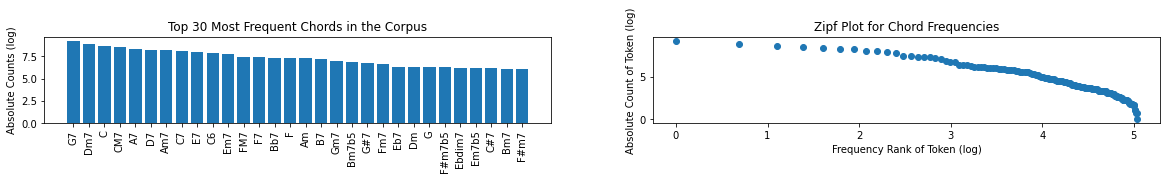

In [116]:
from collections import Counter

counter_of_words = df_chords.set_index('chord').to_dict(orient='dict')
counter_of_words = Counter(counter_of_words['count'])

word_counts = sorted(counter_of_words.values(), reverse=True)
frequency_rank = np.array(list(range(1, len(word_counts) + 1)))

# plot
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)

n = 30
df_top = df_chords_top.head(n)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Chords in the Corpus')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

plt.subplot(1, 2, 2)

plt.scatter(np.log(frequency_rank), np.log(word_counts))
plt.xlabel('Frequency Rank of Token (log)')
plt.ylabel('Absolute Count of Token (log)')
plt.title('Zipf Plot for Chord Frequencies')

plt.subplots_adjust(bottom=0.3, top=0.7)

plt.savefig('plot.png')

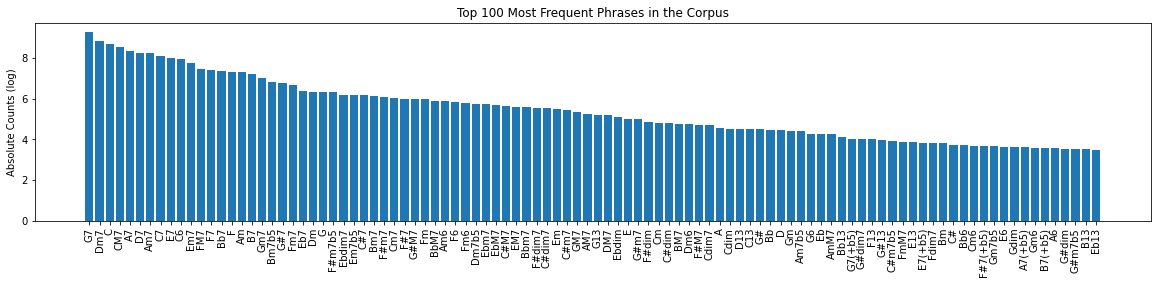

In [117]:
n = 100

plt.figure(figsize=(20, 8))

df_top = df_chords_top.head(n)
plt.subplot(2, 1, 2)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Phrases in the Corpus')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

plt.savefig('plot_top.png')

In [118]:
if use_wandb:
  wandb.log(
      {"corpus": {
              "total_tokens": total_tokens,
              "vocab_size": vocab_size,
              "vocab_proportion_in_corpus": vocab_prop,
              "zipf_plot": wandb.Image('plot.png'),
              "top_plot": wandb.Image('plot_top.png'),
              }
      }
  )

#### Phrases

In [119]:
def make_bigrams(texts, thres=0.2):
  bigram = gensim.models.Phrases(texts, min_count=1, threshold=thres, connector_words=[], scoring='npmi')
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return [bigram_mod[doc] for doc in texts]


thres = 0.6
processed_corpus = make_bigrams(data, thres=thres)

for i in processed_corpus[:10]:
  print(i)

2021-11-29 20:10:57,630 : INFO : collecting all words and their counts
2021-11-29 20:10:57,632 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-11-29 20:10:57,736 : INFO : collected 3969 token types (unigram + bigrams) from a corpus of 79498 words and 1740 sentences
2021-11-29 20:10:57,738 : INFO : merged Phrases<3969 vocab, min_count=1, threshold=0.6, max_vocab_size=40000000>
2021-11-29 20:10:57,739 : INFO : Phrases lifecycle event {'msg': 'built Phrases<3969 vocab, min_count=1, threshold=0.6, max_vocab_size=40000000> in 0.11s', 'datetime': '2021-11-29T20:10:57.739615', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-29 20:10:57,743 : INFO : exporting phrases from Phrases<3969 vocab, min_count=1, threshold=0.6, max_vocab_size=40000000>
2021-11-29 20:10:57,760 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<49 p

['CM7', 'Eb7_G#M7', 'B7', 'EM7', 'G7', 'Gm7_C7', 'FM7', 'G#7', 'C#M7', 'E7', 'Am7', 'D7', 'Dm7_G7', 'CM7', 'Eb7_G#M7', 'B7', 'EM7', 'G7', 'Gm7_C7', 'FM7', 'Eb7_G#M7', 'B7', 'EM7', 'G7', 'CM7', 'Gm7_C7', 'Bm7', 'E7', 'AM7', 'C7', 'FM7', 'Bbm7_Eb7', 'G#M7', 'Dm7_G7', 'CM7', 'Eb7_G#M7', 'B7', 'EM7', 'G7', 'Gm7_C7', 'FM7', 'Eb7_G#M7', 'B7', 'EM7', 'G7', 'CM7']
['Am7', 'Am7', 'Cm7', 'Cm7', 'EbM7', 'EbM7', 'Em7b5', 'A7', 'Dm7', 'Dm7', 'Bm7b5', 'Bm7b5', 'Bbm7', 'Bbm7', 'Fm7', 'Fm7', 'E7', 'E7', 'Fm7', 'Fm7', 'C#M7', 'C#M7', 'Fm7', 'Fm7', 'C#M7', 'C#M7']
['Am7', 'C#M7', 'Bm7b5_E7', 'Am7', 'C#M7', 'Bm7b5_E7', 'Cm7', 'F7', 'BbM7', 'G#m7_C#7', 'F#m7b5_B7', 'EM7', 'EM7', 'E7', 'Am7', 'C#M7', 'Bm7b5_E7', 'Am7', 'C#M7', 'Bm7b5_E7', 'Cm7', 'F7', 'BbM7', 'G#m7_C#7', 'F#m7b5_B7', 'Em7', 'Em7']
['C', 'Am7', 'Dm7_G7', 'C', 'Am7', 'Dm7_G7', 'C', 'Am7', 'Dm7_G7', 'C', 'G7', 'C', 'C', 'Am7', 'Dm7_G7', 'C', 'Am7', 'Dm7_G7', 'C', 'Am7', 'Dm7_G7', 'C', 'G7', 'C', 'C7', 'C7', 'F6', 'F6', 'D7', 'D7', 'G7', 'G7',

In [120]:
processed_corpus[1077]

['CM7',
 'Ebdim7',
 'Dm7_G7',
 'CM7',
 'A7',
 'Dm7_G7',
 'Em7',
 'A7',
 'Dm7_G7',
 'Fm7_Bb7',
 'Em7',
 'A7',
 'Dm7_G7',
 'CM7',
 'Ebdim7',
 'Dm7_G7',
 'CM7',
 'A7',
 'Dm7_G7',
 'Em7',
 'A7',
 'Dm7_G7',
 'C6',
 'C6',
 'C6',
 'F#m7b5_B7',
 'EM7',
 'EM7',
 'F#m7_B7',
 'EM7',
 'EM7',
 'Bbm7b5',
 'Eb7',
 'G#m7',
 'G#m7_C#7',
 'C#7',
 'F#7',
 'F#7',
 'B7',
 'B7',
 'CM7',
 'Ebdim7',
 'Dm7_G7',
 'Gm7_C7',
 'FM7',
 'Bb7',
 'Em7',
 'A7',
 'Dm7_G7',
 'C6',
 'A7',
 'Dm7_G7']

In [121]:
tokens = [item for l in processed_corpus for item in l]
total_tokens = len(tokens)
vocab_size = len(set(tokens))
vocab_prop = 100*vocab_size/total_tokens

df_chords = raw_chords_to_df(processed_corpus)

print(f"Total Number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocab_size}")
print(f"Proportion of vocabulary in corpus: {vocab_prop:.02f}%")

Total Number of tokens: 71100
Size of vocabulary: 200
Proportion of vocabulary in corpus: 0.28%


In [122]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
#df_chords_top = df_chords.query('count > 100')
df_chords_top = df_chords

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

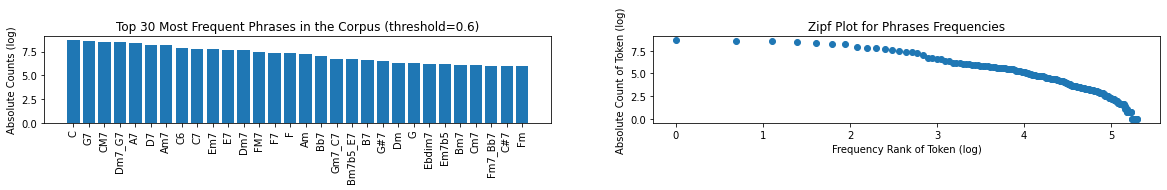

In [123]:
from collections import Counter

counter_of_words = df_chords.set_index('chord').to_dict(orient='dict')
counter_of_words = Counter(counter_of_words['count'])

word_counts = sorted(counter_of_words.values(), reverse=True)
frequency_rank = np.array(list(range(1, len(word_counts) + 1)))

# plot
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)

n = 30
df_top = df_chords_top.head(n)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Phrases in the Corpus (threshold={thres})')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

plt.subplot(1, 2, 2)
plt.scatter(np.log(frequency_rank), np.log(word_counts))
plt.xlabel('Frequency Rank of Token (log)')
plt.ylabel('Absolute Count of Token (log)')
plt.title('Zipf Plot for Phrases Frequencies')

plt.subplots_adjust(bottom=0.3, top=0.7)

plt.savefig('plot.png')

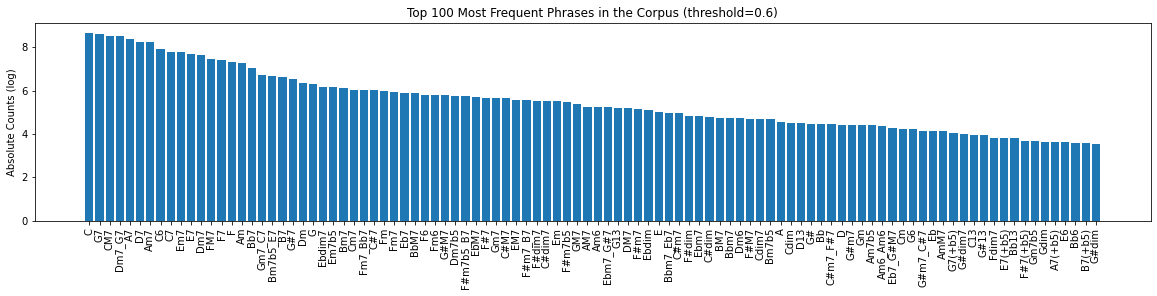

In [124]:
n = 100

plt.figure(figsize=(20, 8))

df_top = df_chords_top.head(n)
plt.subplot(2, 1, 2)
plt.bar(df_top['chord'], np.log(df_top['count']))
plt.xlabel('')
plt.ylabel('Absolute Counts (log)')
plt.title(f'Top {n} Most Frequent Phrases in the Corpus (threshold={thres})')
ax = plt.gca()
ax.set_xticklabels(labels=df_chords_top['chord'],rotation=90);

plt.savefig('plot_top.png')

In [125]:
if use_wandb:
  wandb.log(
      {"phrases": {
              "total_tokens": total_tokens,
              "vocab_size": vocab_size,
              "vocab_proportion_in_corpus": vocab_prop,
              "zipf_plot": wandb.Image('plot.png'),
              "top_plot": wandb.Image('plot_top.png'),
              }
      }
  )

# Test Helpers

In [126]:
!rm -R index
!mkdir index

In [127]:
def get_sim_scores(tunes, index, model):

    df_sim = pd.DataFrame(columns=['reference_title',
                                   'reference_titleid',
                                   'similar_title',
                                   'similar_titleid',
                                   'ref_section', 
                                   'similar_section', 
                                   'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > 30:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                n += 1
            
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                df_sim.loc[len(df_sim)] = [tune,
                                           title_to_titleid[tune],
                                           sectionid_to_title[s2],
                                           sectionid_to_titleid[s2],
                                           sectionid_to_section[s1], 
                                           sectionid_to_section[s2], 
                                           s2_score, 
                                           ]
    return df_sim

In [128]:
def recommend_tune(df, tune_name):

  threshold = 0.5 # arbitrary value, selected based on distribution of max scores

  df_tune = df.query(f'reference_title == "{tune_name}"')
  ff = df_tune.iloc[:]

  # get the maximum similarity score for each section and store in new column
  ff['max'] = ff.groupby('ref_section')['score'].transform('max')

  # consider only results for scores above threshold
  ff = ff.loc[(ff['max'] > threshold)]

  # scale the score with the maxmum value of each section
  ff['score_div_max'] = ff['score'] / ff['max']

  # for each similar title, aggregate all of its sections using the median value
  result = ff.groupby('similar_title').median().sort_values('score_div_max', ascending=False)
    
  # if multiple rows from the same similar tune, keep only the similar_title with the highest score_div_max
  result = result.groupby('similar_title').max('score_div_max').sort_values('score_div_max', ascending=False)

  # add the name of the reference tune
  result['reference'] = tune_name
  result['reference_titleid'] = title_to_titleid[tune_name]

  result = result.reset_index()
  result = result.loc[:, ['reference', 'reference_titleid', 'similar_title', 'score', 'max', 'score_div_max']]
  result['similar_titleid'] = result['similar_title'].apply(lambda x: title_to_titleid[x])
  result = result.reset_index()
  return result, ff

In [129]:
def test_contrafacts(tunes, index, model, N=15):
  matches = 0
  number_of_sections = 0
  results = {}

  for tune, similar_tune in tunes:

    # loop over all sections of the tune
    section_matches = 0
    for s1 in title_to_sectionid[tune]:
      query = processed_corpus[s1]
      query_bow = dictionary.doc2bow(query)

      # perform a similarity query against the corpus
      similarities = index[model[query_bow]]
      sims = sorted(enumerate(similarities), key=lambda item: -item[1])

      # check if the section matches the expected title; consider only the first 15 recommendations
      i = 0
      for sectionid, value in sims:
        if i >= N:
          break
        i += 1
        if sectionid_to_title[sectionid] == similar_tune:
          section_matches += 1

    # for each title, increase matches if at least one of the section matched the expected title
    if section_matches > 0:
      matches += 1  
      results[f'{tune}, {similar_tune}'] = 1
    else:
      results[f'{tune}, {similar_tune}'] = 0
  
  return matches, results

# Train LDA Model

In [130]:
from gensim.test.utils import common_texts
import gensim.models as models
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
id2word = corpora.Dictionary(processed_corpus)

2021-11-29 20:11:40,254 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-29 20:11:40,348 : INFO : built Dictionary(200 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7_Eb7', 'Bm7']...) from 1740 documents (total 71100 corpus positions)
2021-11-29 20:11:40,350 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(200 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7_Eb7', 'Bm7']...) from 1740 documents (total 71100 corpus positions)", 'datetime': '2021-11-29T20:11:40.350401', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [131]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(tune) for tune in processed_corpus]

In [132]:
%%time
TOTAL_TOPICS = 30
lda_model = gensim.models.LdaModel(corpus=corpus, 
                                   id2word=id2word, 
                                   chunksize=200, 
                                   alpha='auto', 
                                   eta='auto', 
                                   #eta=0.1,
                                   random_state=42,
                                   #iterations=500, 
                                   num_topics=TOTAL_TOPICS, 
                                   passes=20, 
                                   per_word_topics=True,
                                   eval_every=None,
                                   update_every=0,  # batch learning, start from scratch everytime (<> online learning)
                                   )

2021-11-29 20:11:44,827 : INFO : using autotuned alpha, starting with [0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335]
2021-11-29 20:11:44,830 : INFO : using serial LDA version on this node
2021-11-29 20:11:44,837 : INFO : running batch LDA training, 30 topics, 20 passes over the supplied corpus of 1740 documents, updating model once every 1740 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
2021-11-29 20:11:44,838 : INFO : PROGRESS: pass 0, at document #200/1740
2021-11-29 20:11:45,006 : INFO : optimized alpha [0.028749231, 0.029594164, 0.028749604, 0.03040694, 0.02947545, 0.031426664, 0.033

CPU times: user 26.3 s, sys: 585 ms, total: 26.9 s
Wall time: 27.5 s


In [133]:
lda_model.print_topics()

2021-11-29 20:12:15,740 : INFO : topic #17 (0.007): 0.078*"Em7" + 0.059*"A7" + 0.055*"C7" + 0.053*"D6" + 0.047*"Gm7b5" + 0.047*"G#7" + 0.042*"FM7" + 0.040*"Dm7_G7" + 0.037*"Am6" + 0.033*"Eb7"
2021-11-29 20:12:15,745 : INFO : topic #1 (0.008): 0.385*"Bm7b5" + 0.128*"Dm7" + 0.073*"E7(+b5)" + 0.071*"D7" + 0.041*"A7" + 0.040*"Cdim" + 0.037*"Am7" + 0.036*"B" + 0.029*"C" + 0.027*"G7"
2021-11-29 20:12:15,749 : INFO : topic #15 (0.011): 0.317*"Bbm7" + 0.182*"G7(+b5)" + 0.158*"G#13" + 0.072*"Bb13" + 0.056*"F#M7" + 0.054*"Eb13" + 0.033*"G#7(+b5)" + 0.023*"F#dim7" + 0.020*"Ebm7" + 0.015*"C#M7"
2021-11-29 20:12:15,752 : INFO : topic #7 (0.012): 0.171*"A7" + 0.128*"Dm7" + 0.083*"D13" + 0.058*"CM7" + 0.057*"G6" + 0.044*"Em7" + 0.040*"D7" + 0.031*"Bb7" + 0.028*"C13" + 0.028*"Am7"
2021-11-29 20:12:15,758 : INFO : topic #10 (0.013): 0.229*"F#m7b5" + 0.068*"G7" + 0.056*"CM7" + 0.047*"F7" + 0.045*"A7" + 0.042*"Am7" + 0.040*"E7" + 0.039*"Dm7_G7" + 0.035*"FM7" + 0.033*"D7"
2021-11-29 20:12:15,760 : INFO : 

[(17,
  '0.078*"Em7" + 0.059*"A7" + 0.055*"C7" + 0.053*"D6" + 0.047*"Gm7b5" + 0.047*"G#7" + 0.042*"FM7" + 0.040*"Dm7_G7" + 0.037*"Am6" + 0.033*"Eb7"'),
 (1,
  '0.385*"Bm7b5" + 0.128*"Dm7" + 0.073*"E7(+b5)" + 0.071*"D7" + 0.041*"A7" + 0.040*"Cdim" + 0.037*"Am7" + 0.036*"B" + 0.029*"C" + 0.027*"G7"'),
 (15,
  '0.317*"Bbm7" + 0.182*"G7(+b5)" + 0.158*"G#13" + 0.072*"Bb13" + 0.056*"F#M7" + 0.054*"Eb13" + 0.033*"G#7(+b5)" + 0.023*"F#dim7" + 0.020*"Ebm7" + 0.015*"C#M7"'),
 (7,
  '0.171*"A7" + 0.128*"Dm7" + 0.083*"D13" + 0.058*"CM7" + 0.057*"G6" + 0.044*"Em7" + 0.040*"D7" + 0.031*"Bb7" + 0.028*"C13" + 0.028*"Am7"'),
 (10,
  '0.229*"F#m7b5" + 0.068*"G7" + 0.056*"CM7" + 0.047*"F7" + 0.045*"A7" + 0.042*"Am7" + 0.040*"E7" + 0.039*"Dm7_G7" + 0.035*"FM7" + 0.033*"D7"'),
 (24,
  '0.261*"Bm7" + 0.147*"Am7" + 0.139*"CM7" + 0.072*"Dm7" + 0.036*"D7" + 0.036*"B7(+b5)" + 0.029*"Fm" + 0.029*"A7(+b5)" + 0.017*"C#7(+b5)" + 0.016*"G#m7"'),
 (25,
  '0.169*"Cdim7" + 0.129*"F" + 0.104*"Gm" + 0.096*"Bb" + 0.084*"E

## Evaluating Topic Model Quality

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [134]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                      texts=data,
                                                      dictionary=id2word, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                         texts=data,
                                                         dictionary=id2word, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

2021-11-29 20:12:18,106 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-11-29 20:12:18,205 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in double_scalars

2021-11-29 20:12:19,585 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-11-29 20:12:20,947 : INFO : -3.289 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 1740 documents with 71100 words


Avg. Coherence Score (Cv): nan
Avg. Coherence Score (UMass): -2.5969261086991224
Model Perplexity: -3.28889771908857


In [135]:
%%time
# Evaluate different Topic Sizes

if False:

  try_topics = [5, 10, 20, 30, 50, 70, 100]

  topic_quality = pd.DataFrame(columns=['num_topics', 'cv', 'umass', 'perp'])

  for t in try_topics:

    lda_model = gensim.models.LdaModel(corpus=corpus, 
                                      id2word=id2word, 
                                      chunksize=200, 
                                      alpha='auto', 
                                      eta='auto', 
                                      #eta=0.1,
                                      random_state=42,
                                      #iterations=500, 
                                      num_topics=t, 
                                      passes=20, 
                                      per_word_topics=True,
                                      eval_every=None,
                                      update_every=0,  # batch learning, start from scratch everytime (<> online learning)
                                      )


    cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                          texts=data,
                                                          dictionary=id2word, 
                                                          coherence='c_v')
    avg_coherence_cv = cv_coherence_model_lda.get_coherence()

    umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                            texts=data,
                                                            dictionary=id2word, 
                                                            coherence='u_mass')
    avg_coherence_umass = umass_coherence_model_lda.get_coherence()

    perplexity = lda_model.log_perplexity(corpus)

    print('Num Topics: ', t)
    print('Avg. Coherence Score (Cv):', avg_coherence_cv)
    print('Avg. Coherence Score (UMass):', avg_coherence_umass)
    print('Model Perplexity:', perplexity)

    topic_quality.loc[len(topic_quality)] =[t, avg_coherence_cv, avg_coherence_umass, perplexity]

    print(topic_quality)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


### Dominant Tunes in Topics

In [136]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=20)] 
                   for n in range(0, lda_model.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T


In [137]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['TermsPerTopic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)]
                         )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [138]:
titles.head()

,id,tune_id,section_id,section_name,title,title_playlist,tune_mode
0,0,0,0,NaN,26-2,26-2 [jazz1350],major
1,1,1,0,NaN,500 Miles High,500 Miles High [jazz1350],minor
2,2,2,0,NaN,502 Blues,502 Blues [jazz1350],minor
3,3,3,0,NaN,52nd Street Theme,52nd Street Theme [jazz1350],major
4,4,4,0,NaN,9.20 Special,9.20 Special [jazz1350],major


In [139]:
corpus_topics = [sorted(topics[0], key=lambda record: -record[1])[0] for topics in lda_model[corpus] ]

In [140]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(data))
corpus_topic_df['DominantTopic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution%'] = [round(item[1]*100, 2) for item in corpus_topics]
#corpus_topic_df['TopicDesc'] = [topics_df.iloc[t[0]]['TermsPerTopic'] for t in corpus_topics]
corpus_topic_df['Tunes'] = processed_corpus
corpus_topic_df['Title'] = titles['title_playlist']
corpus_topic_df['Section'] = titles['section_id'].map(str) + '_' + titles['section_name'].map(str)


In [141]:
corpus_topic_df.groupby('DominantTopic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution%'], 
                                                                                         ascending=False)
                                                                             .iloc[0])
)


,Document,DominantTopic,Contribution%,Tunes,Title,Section
DominantTopic,,,,,,
1,1323,1,62.12,"[G#m7b5, C#7, F#m7_B7, Bm7, E7, Am7, F#7, G#m7b5, C#7, F#m7, F#m, Ebm7b5, G#7, D7, C#7, G#m7b5, C#7, F#m7_B7, Bm7, E7, G7, F#7, Bm7, G7, C#7, F#7, F7, E7, Am7, B, Bb]",You Won't Forget Me [jazz1350],0_nan
2,1128,2,56.97,"[Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, A7, Dm7, Dm7, E7, E7, FM7, FM7, Bm7b5, E7(+b5), Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5]",Sunshower [jazz1350],0_nan
3,382,3,71.57,"[Am, Am, Am, Am, Am, Am, E7, Am, Am, Am, Am, Am, Am, Am, E7, Am, E7, Am, E7, Am, E7, Am, E7, Am]",Fever [jazz1350],0_nan
4,1398,4,98.56,"[C, C, C, C, C, G7, C, C7, F, F, C, C, G7, G7, C, C, F, F, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C7, F, F#dim7, C, A7, D7, G7, C, F, F, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, C, C, C, C, C, G7, C]",Bogalusa Strut [trad],0_nan
5,1106,5,50.73,"[C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7]",Straight Life [jazz1350],0_nan
6,1149,6,98.64,"[GM7, GM7, F#m7, F#m7, GM7, GM7, F#m7, F#m7, GM7, GM7, F#m7, F#m7, GM7, F#m7, CM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, F#m7_B7, EM7, E7, Eb7, DM7, C#7, CM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, B7, Bb7, A7, G#m7, Em7, C#m7, Ebm7, Em7, F#m7, GM7, GM7, F#m7, F#m7, Em7, A13, DM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, EM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, BM7]",Tell me a bedtime story [jazz1350],0_nan
7,346,7,97.60,"[Dm7_G7, Em7, Am7, Dm7_G7, CM7, Em7, Dm7_G7, Em7, Am7, Dm7_G7, CM7, A7, Dm7_G7, Em7, Am7, Dm7_G7, CM7, Em7, Dm7_G7, Em7, Am7, Dm7_G7, CM7, Gm7_C7, FM7, FM7, Am7, D7, Dm7_G7, A7, Dm7_G7, Em7, Am7, Dm7_G7, CM7, Em7, Dm7_G7, Em7, Am7, Dm7_G7, CM7, A7]",Eclypso [jazz1350],0_nan
8,766,8,97.15,"[A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, FM7, G6, FM7, G6, FM7, G6, FM7, G6, F#7, Gm7_C7, FM7, Fm7_Bb7, A7, G6, A7, G6, A7, G6, A7, G6]",Mahjong [jazz1350],0_nan
9,269,9,65.83,"[B7, B7, B7, B7, B7, B7, B7, B7, B7, B7, C#7, C#7, C7, C7, B7, B7, Bb7, Bb7, A7, F#7, Bm, F#7, Bm, F#7, B7, B7, B7, B7, B7, B7, C#7, C#7, C7, C7, B7, B7, Bb7, Bb7, A7, Bm, G7, C#m7b5_F#7, Bm, G#m, C#7, Ebm, D7, C#m, F#7, B7, B7, C#7, C#7, C7, C7, B7, B7, Bb7, Bb7, A7, F#7, Bm, F#7, Bm_Bm, Bm, F#7]",Crisis [jazz1350],0_nan


### List the Tunes of the individual Topics

In [142]:
def display_tunes_per_topic(df, topic):
  tunes = df.query(f"DominantTopic == {topic}").sort_values('Contribution%', ascending=False)
  print(f"\n*** TOPIC {n} ***")
  print(f"{len(tunes)} tunes")
  return tunes

In [143]:
topic_result = corpus_topic_df.loc[:, ['DominantTopic', 'Contribution%', 'Title', 'Section', 'Tunes']]

In [144]:
for n in range(1, TOTAL_TOPICS+1):
  print(display_tunes_per_topic(topic_result, topic=n).head(30))


*** TOPIC 1 ***
18 tunes
      DominantTopic  Contribution%                                 Title Section                                                                                                                                                                                                                                                                                                                             Tunes
1323  1              62.12          You Won't Forget Me [jazz1350]        0_nan   [G#m7b5, C#7, F#m7_B7, Bm7, E7, Am7, F#7, G#m7b5, C#7, F#m7, F#m, Ebm7b5, G#7, D7, C#7, G#m7b5, C#7, F#m7_B7, Bm7, E7, G7, F#7, Bm7, G7, C#7, F#7, F7, E7, Am7, B, Bb]                                                                                                                                                          
356   1              60.73          Epistrophy [jazz1350]                 0_nan   [C7, C#7, C7, C#7, C7, C#7, C7, C#7, D7, Eb7, D7, Eb7, D7, Eb7, D7, Eb7, D7, Eb7, D7, 

## Visualizing Topics

In [145]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='pcoa')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.290510  0.188514  1       1        15.434154
27    -0.186469  0.126716  2       1        10.848548
29    -0.129658  0.152699  3       1        7.642257 
28     0.004137  0.208232  4       1        6.269385 
9     -0.171323  0.115628  5       1        6.228973 
6     -0.220646  0.094980  6       1        5.085973 
11     0.212215  0.194821  7       1        5.003955 
13    -0.114081 -0.082738  8       1        4.896474 
16    -0.201457 -0.059867  9       1        3.331318 
26     0.185559 -0.032450  10      1        3.193022 
23    -0.052962  0.005001  11      1        2.861812 
12     0.170551  0.013529  12      1        2.664564 
2      0.157628 -0.084716  13      1        2.483906 
5     -0.174913 -0.082741  14      1        2.404720 
20    -0.104661 -0.268106  15      1        1.988760 
21     0.105688 -0.278950  16      1        1.898048 
14    -0.112851  0.062557  17      1        1.891159 
0      0.046776 -0.103135  18      1        1.789261 
4      0.133048 -0.036446  19      1        1.765269 
22    -0.134117  0.004937  20      1        1.759749 
18    -0.007518 -0.201375  21      1        1.688770 
8      0.172237  0.084197  22      1        1.527056 
7     -0.147142  0.047514  23      1        1.471692 
19     0.248518  0.024537  24      1        1.452751 
24    -0.152598 -0.050471  25      1        1.168740 
10    -0.089287  0.075237  26      1        1.025283 
25     0.249505  0.044059  27      1        0.878609 
17    -0.076294  0.040769  28      1        0.565562 
15     0.116304 -0.300573  29      1        0.446367 
1     -0.016700  0.097641  30      1        0.333862 , topic_info=      Term         Freq        Total Category  logprob  loglift
32  C       5675.000000  5675.000000  Default  30.0000  30.0000
1   Am7     3811.000000  3811.000000  Default  29.0000  29.0000
16  G7      5598.000000  5598.000000  Default  28.0000  28.0000
6   C7      2398.000000  2398.000000  Default  27.0000  27.0000
74  Am      1486.000000  1486.000000  Default  26.0000  26.0000
..  ..              ...          ...      ...      ...      ...
7   CM7     0.531656     5124.818503  Topic30 -6.1014  -3.4714 
70  Dm7b5   0.191899     349.738442   Topic30 -7.1204  -1.8058 
47  Ebdim7  0.184265     503.242721   Topic30 -7.1610  -2.2103 
6   C7      0.252504     2398.845451  Topic30 -6.8460  -3.4569 
93  Dm      0.174350     561.077216   Topic30 -7.2163  -2.3744 

[1349 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
113   1      0.060739  A        
113   4      0.010123  A        
113   7      0.131601  A        
113   11     0.010123  A        
113   24     0.779484  A        
...   ..          ... ..        
57    24     0.026555  Gm7b5    
57    27     0.079664  Gm7b5    
57    28     0.504538  Gm7b5    
185   28     0.534137  GmM7     
186   28     0.534137  GmM7_GmM7

[1283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 28, 30, 29, 10, 7, 12, 14, 17, 27, 24, 13, 3, 6, 21, 22, 15, 1, 5, 23, 19, 9, 8, 20, 25, 11, 26, 18, 16, 2])

In [146]:
with open('pyldavis.html', 'w') as f:
  pyLDAvis.save_html(vis, f)

In [147]:
if use_wandb:
  artifact = wandb.Artifact('lda_vis', type='html')
  artifact.add_file('pyldavis.html')
  wandb.log_artifact(artifact)

## Distance Metrics


In [148]:
from gensim.matutils import jaccard

# element 0 of the result from lda_model contains the topics that a tune belongs to, with the respective probabilities
jaccard(lda_model[corpus[505]][0], lda_model[corpus[925]][0])

0.835400645488711

In [149]:
topic_result.loc[:, ['DominantTopic']].to_csv('topics.csv', index=True, index_label='id')

# W&B Logging and Finish

In [150]:
if use_wandb:
  wandb.finish()